MSDS 684 - Lab 5
Semi-gradient SARSA with Tile Coding on MountainCar-v0

This script:
- Implements tile coding from scratch using NumPy (configurable tilings/tiles/offsets)
- Solves MountainCar-v0 using semi-gradient SARSA with linear function approximation
- Tracks steps per episode (learning curve)
- Saves numeric data for each graph so you can share results
- Prints numeric summaries to the console
- Generates:
    1. Learning curve (steps per episode)
    2. Value function heatmap: max_a Q(s, a) over (position, velocity)
    3. Greedy policy map across the state space
    4. Sample greedy trajectories overlayed on the value function
    5. Convergence curves for different feature configurations

=== Training baseline config: 8 tilings, 8x8 tiles ===
Episode 50/500 - steps: 200, epsilon: 0.778
Episode 100/500 - steps: 200, epsilon: 0.606
Episode 150/500 - steps: 200, epsilon: 0.471
Episode 200/500 - steps: 200, epsilon: 0.367
Episode 250/500 - steps: 200, epsilon: 0.286
Episode 300/500 - steps: 200, epsilon: 0.222
Episode 350/500 - steps: 154, epsilon: 0.173
Episode 400/500 - steps: 157, epsilon: 0.135
Episode 450/500 - steps: 156, epsilon: 0.105
Episode 500/500 - steps: 148, epsilon: 0.082

=== Learning Curve (Steps per Episode) ===
Total episodes: 500
First 10 episodes: [200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
Last 10 episodes:  [122, 115, 186, 113, 149, 117, 116, 150, 161, 148]
Mean steps over last 50 episodes: 141.12


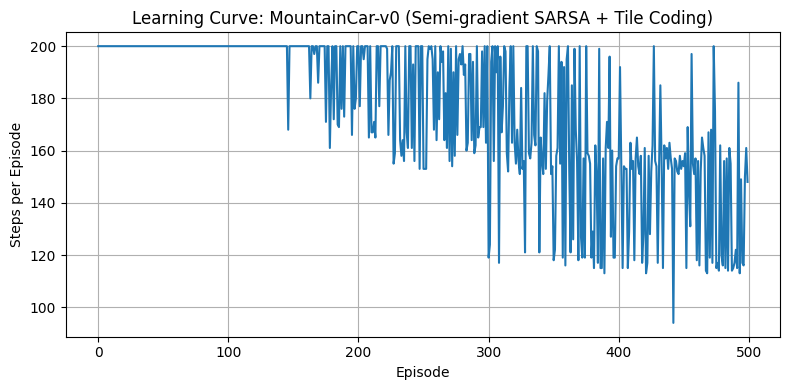


=== Value Function Grid (max_a Q(s,a)) ===
Grid shape: (60, 60) (vel x pos)
Min value: -96.1392
Max value: 1.0430
Middle velocity row (first 10 positions): [-34.016, -34.016, -36.091, -38.902, -41.606, -45.0, -48.112, -50.269, -52.319, -53.845]


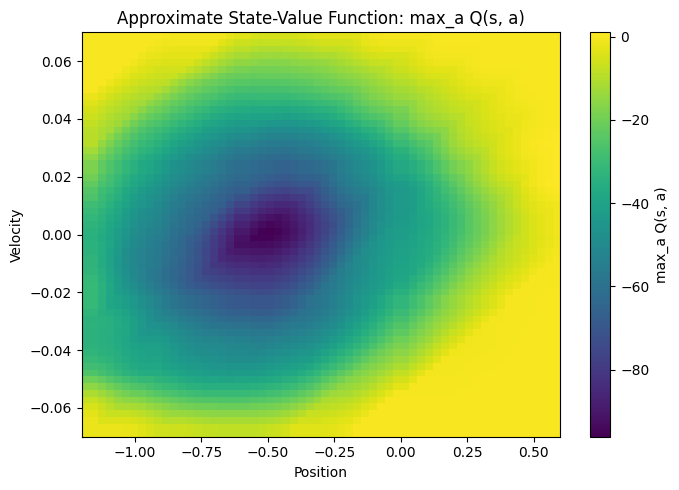


=== Greedy Policy Grid ===
Action 0: 1375 cells (38.2%)
Action 1: 753 cells (20.9%)
Action 2: 1472 cells (40.9%)


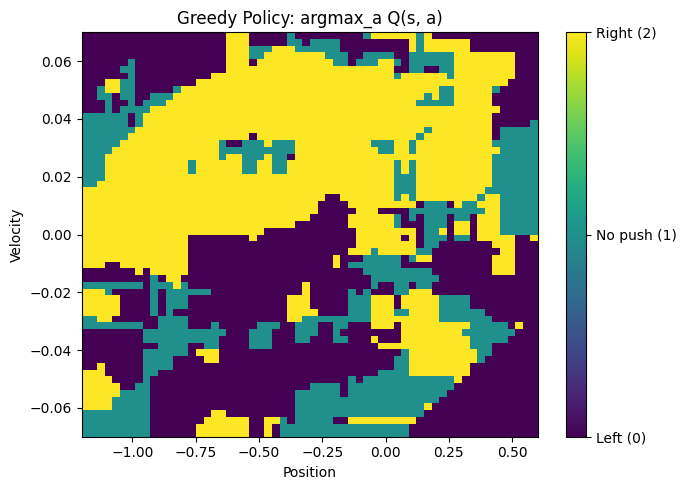


=== Greedy Trajectories ===
Trajectory 1: 111 steps
Trajectory 2: 148 steps
Trajectory 3: 150 steps
Trajectory 4: 151 steps
Trajectory 5: 111 steps


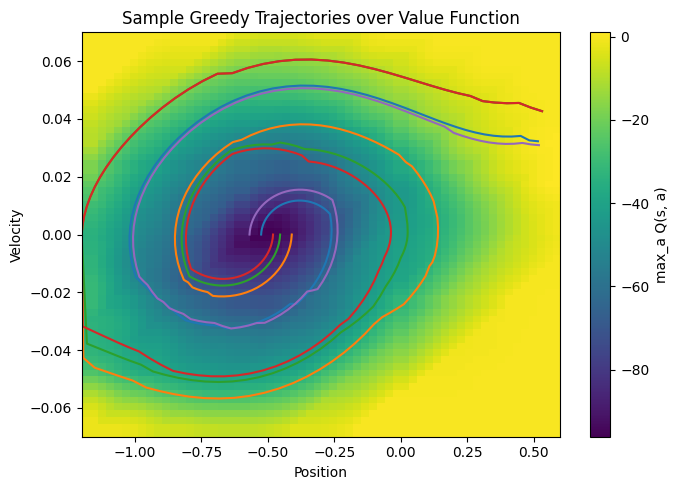


=== Running config: 4 tilings, 4x4 ===

=== Running config: 8 tilings, 8x8 ===

=== Running config: 16 tilings, 8x8 ===

=== Convergence Summary (steps per episode) ===
4 tilings, 4x4: final episode=200, mean of last 50 episodes=185.08
8 tilings, 8x8: final episode=156, mean of last 50 episodes=175.86
16 tilings, 8x8: final episode=188, mean of last 50 episodes=180.54


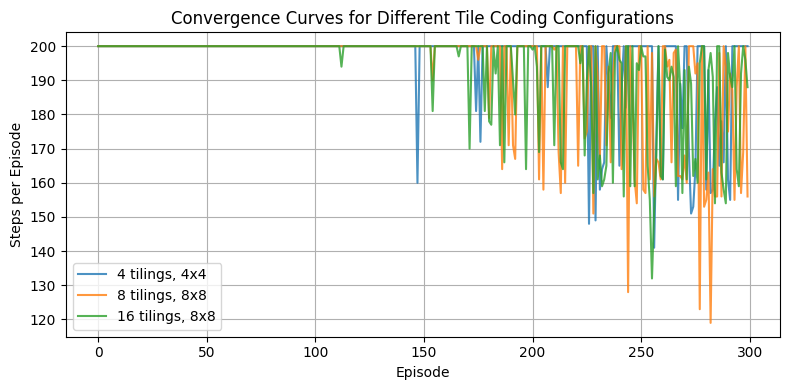

Convergence plot + data saved to lab5_outputs\convergence_feature_configs.png, lab5_outputs\data\convergence_feature_configs.csv

Training complete. All figures in: C:\Users\nikhs\Downloads\Reinforcement Learning\Lab5\lab5_outputs
Numeric data for graphs in: C:\Users\nikhs\Downloads\Reinforcement Learning\Lab5\lab5_outputs\data


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

# Tile Coding Implementation
class TileCoder:
    """
    Uniform tile coder for 2D continuous observations (position, velocity).

    - num_tilings: number of overlapping tilings
    - tiles_per_dim: number of tiles per dimension per tiling

    Features:
    - Discretizes the continuous observation space into overlapping grids
    - For each tiling, computes which tile the state falls into
    - Returns either:
        * indices of active tiles, or
        * a sparse binary feature vector via get_feature_vector()
    """
    def __init__(self, obs_low, obs_high, num_tilings=8, tiles_per_dim=8):
        self.obs_low = np.array(obs_low, dtype=np.float64)
        self.obs_high = np.array(obs_high, dtype=np.float64)
        self.num_dims = len(self.obs_low)

        assert self.num_dims == 2, "TileCoder is designed for 2D states (position, velocity)."

        self.num_tilings = num_tilings
        self.tiles_per_dim = tiles_per_dim

        # Width of each tile in each dimension
        # (tiles_per_dim - 1) so that edges align with obs_high
        self.tile_width = (self.obs_high - self.obs_low) / (self.tiles_per_dim - 1)

        # Offsets for each tiling to create overlapping grids
        offsets = []
        for tiling_idx in range(self.num_tilings):
            frac = tiling_idx / self.num_tilings  # goes from 0 to (num_tilings-1)/num_tilings
            offset = frac * self.tile_width
            offsets.append(offset)
        self.offsets = np.array(offsets)

        # Total number of tiles per tiling and overall feature dimension
        self.tiles_per_tiling = (self.tiles_per_dim ** self.num_dims)
        self.n_features = self.num_tilings * self.tiles_per_tiling

    def get_tile_indices(self, state):
        """
        Given a continuous state (position, velocity), return a 1D NumPy array
        of active tile indices across all tilings (one per tiling).
        """
        state = np.array(state, dtype=np.float64)
        state = np.clip(state, self.obs_low, self.obs_high)

        active_indices = []

        for tiling_idx in range(self.num_tilings):
            offset = self.offsets[tiling_idx]

            # Shift state by offset and scale by tile width to get tile coordinates
            coords = ((state - self.obs_low + offset) / self.tile_width).astype(int)

            # Clamp to [0, tiles_per_dim-1]
            coords = np.clip(coords, 0, self.tiles_per_dim - 1)

            # Flatten (i, j) -> index within this tiling
            tile_index_within_tiling = np.ravel_multi_index(
                coords,
                dims=(self.tiles_per_dim, self.tiles_per_dim)
            )

            # Global index across all tilings
            global_index = tiling_idx * self.tiles_per_tiling + tile_index_within_tiling
            active_indices.append(global_index)

        return np.array(active_indices, dtype=int)

    def get_feature_vector(self, state):
        """
        Return a sparse binary feature vector for the given state.
        Mostly for completeness; we usually just work with indices.
        """
        indices = self.get_tile_indices(state)
        x = np.zeros(self.n_features, dtype=np.float64)
        x[indices] = 1.0
        return x


# Semi-gradient SARSA Agent
class SemiGradientSarsaAgent:
    """
    Semi-gradient SARSA agent with linear function approximation:

        Q(s, a) = w_a^T x(s)

    where:
    - x(s) is a sparse binary feature vector from tile coding
    - w_a is a separate weight vector per action
    """
    def __init__(
        self,
        env,
        tilecoder: TileCoder,
        alpha=0.1,
        gamma=1.0,
        epsilon_start=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
    ):
        self.env = env
        self.tc = tilecoder

        self.n_actions = env.action_space.n
        self.gamma = gamma

        # Scale alpha by number of tilings (common heuristic for tile coding)
        self.alpha = alpha / self.tc.num_tilings

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Weight matrix: one weight vector per action
        self.w = np.zeros((self.n_actions, self.tc.n_features), dtype=np.float64)

    # ---------- Q-value helpers ----------

    def q_value(self, state, action):
        indices = self.tc.get_tile_indices(state)
        return np.sum(self.w[action, indices])

    def q_values(self, state):
        indices = self.tc.get_tile_indices(state)
        return np.array([np.sum(self.w[a, indices]) for a in range(self.n_actions)])

    # ---------- Policy ----------

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        q_vals = self.q_values(state)
        return int(np.argmax(q_vals))

    def greedy_action(self, state):
        q_vals = self.q_values(state)
        return int(np.argmax(q_vals))

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    # ---------- Training ----------

    def train(self, num_episodes=500, max_steps_per_episode=200, verbose=True):
        """
        Train with semi-gradient SARSA.

        Returns:
            episode_lengths: list of steps taken per episode
        """
        episode_lengths = []

        for ep in range(num_episodes):
            state, _ = self.env.reset()
            action = self.select_action(state)

            steps = 0
            done = False

            while not done and steps < max_steps_per_episode:
                indices = self.tc.get_tile_indices(state)
                q_sa = np.sum(self.w[action, indices])

                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                steps += 1

                if done:
                    target = reward
                    td_error = target - q_sa
                else:
                    next_action = self.select_action(next_state)
                    next_indices = self.tc.get_tile_indices(next_state)
                    q_snext_anext = np.sum(self.w[next_action, next_indices])
                    target = reward + self.gamma * q_snext_anext
                    td_error = target - q_sa

                # Semi-gradient update only on active features
                self.w[action, indices] += self.alpha * td_error

                if not done:
                    state = next_state
                    action = next_action

            self.decay_epsilon()
            episode_lengths.append(steps)

            if verbose and (ep + 1) % 50 == 0:
                print(
                    f"Episode {ep + 1}/{num_episodes} - "
                    f"steps: {steps}, epsilon: {self.epsilon:.3f}"
                )

        return episode_lengths

    # ---------- Greedy rollout for visualization ----------

    def run_greedy_episode(self, max_steps=200, start_state=None):
        """
        Run an episode with greedy (exploit-only) policy and optionally set a custom start state.
        Returns:
            traj_states: array of visited states
            steps: number of steps taken
        """
        state, _ = self.env.reset()
        if start_state is not None:
            # Directly manipulate underlying state
            self.env.unwrapped.state = np.array(start_state, dtype=np.float64)
            state = np.array(start_state, dtype=np.float64)

        done = False
        steps = 0
        traj_states = [state.copy()]

        while not done and steps < max_steps:
            action = self.greedy_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            steps += 1
            state = next_state
            traj_states.append(state.copy())

        return np.array(traj_states), steps


# Visualization + Data Saving Utilities
def plot_learning_curve(episode_lengths, out_path_fig, out_path_csv):
    """
    Plot and save the learning curve.
    Also saves raw episode lengths to CSV and prints summary statistics.
    """
    episode_lengths = np.array(episode_lengths, dtype=np.int32)

    # Save raw numbers
    header = "steps_per_episode"
    np.savetxt(out_path_csv, episode_lengths, delimiter=",", header=header, comments="")

    # Print numeric summary
    print("\n=== Learning Curve (Steps per Episode) ===")
    print(f"Total episodes: {len(episode_lengths)}")
    print(f"First 10 episodes: {episode_lengths[:10].tolist()}")
    print(f"Last 10 episodes:  {episode_lengths[-10:].tolist()}")
    if len(episode_lengths) >= 50:
        last50_mean = episode_lengths[-50:].mean()
        print(f"Mean steps over last 50 episodes: {last50_mean:.2f}")
    else:
        print("Not enough episodes to compute last-50 mean.")

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.title("Learning Curve: MountainCar-v0 (Semi-gradient SARSA + Tile Coding)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path_fig)
    plt.close()


def plot_value_function(agent, tc, out_path_fig, out_path_npz, num_points_per_dim=60):
    """
    Compute value grid V(s) = max_a Q(s,a), save numeric data, and plot heatmap.
    Also prints basic stats for the grid.
    """
    pos_vals = np.linspace(tc.obs_low[0], tc.obs_high[0], num_points_per_dim)
    vel_vals = np.linspace(tc.obs_low[1], tc.obs_high[1], num_points_per_dim)

    value_grid = np.zeros((num_points_per_dim, num_points_per_dim), dtype=np.float64)

    for i, p in enumerate(pos_vals):
        for j, v in enumerate(vel_vals):
            state = np.array([p, v], dtype=np.float64)
            q_vals = agent.q_values(state)
            value_grid[j, i] = np.max(q_vals)  # (j, i) for imshow (y, x)

    # Save numeric data
    np.savez(out_path_npz, pos=pos_vals, vel=vel_vals, value_grid=value_grid)

    # Print numeric summary
    print("\n=== Value Function Grid (max_a Q(s,a)) ===")
    print(f"Grid shape: {value_grid.shape} (vel x pos)")
    print(f"Min value: {value_grid.min():.4f}")
    print(f"Max value: {value_grid.max():.4f}")
    mid_row = value_grid[value_grid.shape[0] // 2]
    print(f"Middle velocity row (first 10 positions): {mid_row[:10].round(3).tolist()}")

    # Plot
    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        value_grid,
        origin="lower",
        aspect="auto",
        extent=[
            tc.obs_low[0],
            tc.obs_high[0],
            tc.obs_low[1],
            tc.obs_high[1],
        ],
    )
    plt.colorbar(im, label="max_a Q(s, a)")
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Approximate State-Value Function: max_a Q(s, a)")
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path_fig)
    plt.close()


def plot_policy(agent, tc, out_path_fig, out_path_npy, num_points_per_dim=60):
    """
    Compute greedy policy map over state space, save action grid, and plot.
    Also prints how many cells choose each action.
    """
    pos_vals = np.linspace(tc.obs_low[0], tc.obs_high[0], num_points_per_dim)
    vel_vals = np.linspace(tc.obs_low[1], tc.obs_high[1], num_points_per_dim)

    policy_grid = np.zeros((num_points_per_dim, num_points_per_dim), dtype=int)

    for i, p in enumerate(pos_vals):
        for j, v in enumerate(vel_vals):
            state = np.array([p, v], dtype=np.float64)
            action = agent.greedy_action(state)
            policy_grid[j, i] = action  # (j, i) for imshow

    # Save numeric policy grid
    np.save(out_path_npy, policy_grid)

    # Print numeric summary
    print("\n=== Greedy Policy Grid ===")
    unique, counts = np.unique(policy_grid, return_counts=True)
    total_cells = policy_grid.size
    for a, c in zip(unique, counts):
        pct = 100.0 * c / total_cells
        print(f"Action {a}: {c} cells ({pct:.1f}%)")

    # Plot
    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        policy_grid,
        origin="lower",
        aspect="auto",
        extent=[
            tc.obs_low[0],
            tc.obs_high[0],
            tc.obs_low[1],
            tc.obs_high[1],
        ],
        interpolation="nearest",
    )
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(["Left (0)", "No push (1)", "Right (2)"])
    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Greedy Policy: argmax_a Q(s, a)")
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path_fig)
    plt.close()


def plot_trajectories_over_value(
    agent,
    tc,
    out_path_fig,
    out_path_npz,
    num_traj=5,
    max_steps=200,
    num_points_per_dim=60,
):
    """
    Overlay several greedy trajectories and save numeric data.
    Also prints length of each trajectory.
    """
    pos_vals = np.linspace(tc.obs_low[0], tc.obs_high[0], num_points_per_dim)
    vel_vals = np.linspace(tc.obs_low[1], tc.obs_high[1], num_points_per_dim)

    value_grid = np.zeros((num_points_per_dim, num_points_per_dim), dtype=np.float64)
    for i, p in enumerate(pos_vals):
        for j, v in enumerate(vel_vals):
            state = np.array([p, v], dtype=np.float64)
            q_vals = agent.q_values(state)
            value_grid[j, i] = np.max(q_vals)

    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        value_grid,
        origin="lower",
        aspect="auto",
        extent=[
            tc.obs_low[0],
            tc.obs_high[0],
            tc.obs_low[1],
            tc.obs_high[1],
        ],
    )
    plt.colorbar(im, label="max_a Q(s, a)")

    rng = np.random.RandomState(42)
    trajectories = []
    lengths = []

    for k in range(num_traj):
        start_pos = rng.uniform(-0.6, -0.4)
        start_vel = 0.0
        traj_states, steps = agent.run_greedy_episode(
            max_steps=max_steps,
            start_state=[start_pos, start_vel],
        )
        trajectories.append(traj_states)
        lengths.append(steps)
        plt.plot(traj_states[:, 0], traj_states[:, 1], linewidth=1.5)

    # Save numeric data (grid + trajectories)
    np.savez(
        out_path_npz,
        pos=pos_vals,
        vel=vel_vals,
        value_grid=value_grid,
        trajectories=np.array(trajectories, dtype=object),
    )

    # Print numeric summary
    print("\n=== Greedy Trajectories ===")
    for i, L in enumerate(lengths, start=1):
        print(f"Trajectory {i}: {L} steps")

    plt.xlabel("Position")
    plt.ylabel("Velocity")
    plt.title("Sample Greedy Trajectories over Value Function")
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path_fig)
    plt.close()


# Convergence Curves for Different Feature Configurations
def experiment_feature_configs(
    env_name,
    configs,
    num_episodes=300,
    max_steps=200,
    out_path_fig="convergence_feature_configs.png",
    out_path_csv="convergence_feature_configs.csv",
):
    """
    Run semi-gradient SARSA with different tile coding configs.
    Save convergence curves and print summary stats.
    """
    all_curves = []

    for cfg in configs:
        print(f"\n=== Running config: {cfg['label']} ===")

        env = gym.make(env_name)

        tilecoder = TileCoder(
            obs_low=env.observation_space.low,
            obs_high=env.observation_space.high,
            num_tilings=cfg["num_tilings"],
            tiles_per_dim=cfg["tiles_per_dim"],
        )

        agent = SemiGradientSarsaAgent(
            env=env,
            tilecoder=tilecoder,
            alpha=0.1,
            gamma=1.0,
            epsilon_start=1.0,
            epsilon_min=0.01,
            epsilon_decay=0.995,
        )

        ep_lengths = agent.train(
            num_episodes=num_episodes,
            max_steps_per_episode=max_steps,
            verbose=False,
        )
        curve = np.array(ep_lengths, dtype=np.int32)
        all_curves.append((cfg["label"], curve))

        env.close()

    # Save to CSV
    max_len = max(len(c[1]) for c in all_curves)
    data = np.full((max_len, len(all_curves) + 1), np.nan)
    data[:, 0] = np.arange(1, max_len + 1)
    header_cols = ["episode"]

    for j, (label, curve) in enumerate(all_curves, start=1):
        data[: len(curve), j] = curve
        header_cols.append(label.replace(",", "_"))

    header = ",".join(header_cols)
    np.savetxt(out_path_csv, data, delimiter=",", header=header, comments="")

    # Print numeric summary
    print("\n=== Convergence Summary (steps per episode) ===")
    for label, curve in all_curves:
        last50 = curve[-50:] if len(curve) >= 50 else curve
        print(
            f"{label}: final episode={curve[-1]}, "
            f"mean of last {len(last50)} episodes={last50.mean():.2f}"
        )

    # Plot
    plt.figure(figsize=(8, 4))
    for label, curve in all_curves:
        plt.plot(curve, label=label, alpha=0.8)
    plt.xlabel("Episode")
    plt.ylabel("Steps per Episode")
    plt.title("Convergence Curves for Different Tile Coding Configurations")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path_fig)
    plt.close()
    print(f"Convergence plot + data saved to {out_path_fig}, {out_path_csv}")


# Main Entry Point
def main():
    OUTPUT_DIR = "lab5_outputs"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    DATA_DIR = os.path.join(OUTPUT_DIR, "data")
    os.makedirs(DATA_DIR, exist_ok=True)

    # ---------- Baseline config: 8 tilings of 8x8 tiles ----------
    env = gym.make("MountainCar-v0")

    obs_low = env.observation_space.low
    obs_high = env.observation_space.high

    NUM_TILINGS = 8
    TILES_PER_DIM = 8

    tilecoder = TileCoder(
        obs_low=obs_low,
        obs_high=obs_high,
        num_tilings=NUM_TILINGS,
        tiles_per_dim=TILES_PER_DIM,
    )

    agent = SemiGradientSarsaAgent(
        env=env,
        tilecoder=tilecoder,
        alpha=0.1,         # scaled inside by num_tilings
        gamma=1.0,
        epsilon_start=1.0,
        epsilon_min=0.01,
        epsilon_decay=0.995,
    )

    NUM_EPISODES = 500
    MAX_STEPS_PER_EPISODE = 200

    print("=== Training baseline config: 8 tilings, 8x8 tiles ===")
    episode_lengths = agent.train(
        num_episodes=NUM_EPISODES,
        max_steps_per_episode=MAX_STEPS_PER_EPISODE,
        verbose=True,
    )

    # ---------- Plots + Data for the baseline config ----------

    # Learning curve
    plot_learning_curve(
        episode_lengths,
        out_path_fig=os.path.join(OUTPUT_DIR, "learning_curve_steps_per_episode.png"),
        out_path_csv=os.path.join(DATA_DIR, "learning_curve_steps_per_episode.csv"),
    )

    # Value function heatmap
    plot_value_function(
        agent,
        tilecoder,
        out_path_fig=os.path.join(OUTPUT_DIR, "value_function_heatmap.png"),
        out_path_npz=os.path.join(DATA_DIR, "value_function_grid.npz"),
        num_points_per_dim=60,
    )

    # Policy map
    plot_policy(
        agent,
        tilecoder,
        out_path_fig=os.path.join(OUTPUT_DIR, "policy_map.png"),
        out_path_npy=os.path.join(DATA_DIR, "policy_grid.npy"),
        num_points_per_dim=60,
    )

    # Trajectories over value function
    plot_trajectories_over_value(
        agent,
        tilecoder,
        out_path_fig=os.path.join(OUTPUT_DIR, "trajectories_over_value.png"),
        out_path_npz=os.path.join(DATA_DIR, "trajectories_over_value.npz"),
        num_traj=5,
        max_steps=200,
        num_points_per_dim=60,
    )

    env.close()

    # ---------- Convergence curves for different feature configs ----------
    experiment_feature_configs(
        env_name="MountainCar-v0",
        configs=[
            {"label": "4 tilings, 4x4", "num_tilings": 4, "tiles_per_dim": 4},
            {"label": "8 tilings, 8x8", "num_tilings": 8, "tiles_per_dim": 8},
            {"label": "16 tilings, 8x8", "num_tilings": 16, "tiles_per_dim": 8},
        ],
        num_episodes=300,
        max_steps=200,
        out_path_fig=os.path.join(OUTPUT_DIR, "convergence_feature_configs.png"),
        out_path_csv=os.path.join(DATA_DIR, "convergence_feature_configs.csv"),
    )

    print(f"\nTraining complete. All figures in: {os.path.abspath(OUTPUT_DIR)}")
    print(f"Numeric data for graphs in: {os.path.abspath(DATA_DIR)}")


if __name__ == "__main__":
    main()


## EXTRA EXPERIMENTS (SEPARATE FROM MAIN):
 - Compare epsilon schedules
 - Compare learning rates (alpha)


=== Epsilon schedule experiment: Fast decay (0.99) ===
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5

=== Epsilon schedule experiment: Medium decay (0.995) ===
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5

=== Epsilon schedule experiment: Slow decay (0.999) ===
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5

=== Epsilon schedule convergence summary ===
Fast decay (0.99): final=136.60, last-50 mean=154.97
Medium decay (0.995): final=174.80, last-50 mean=174.48
Slow decay (0.999): final=200.00, last-50 mean=200.00


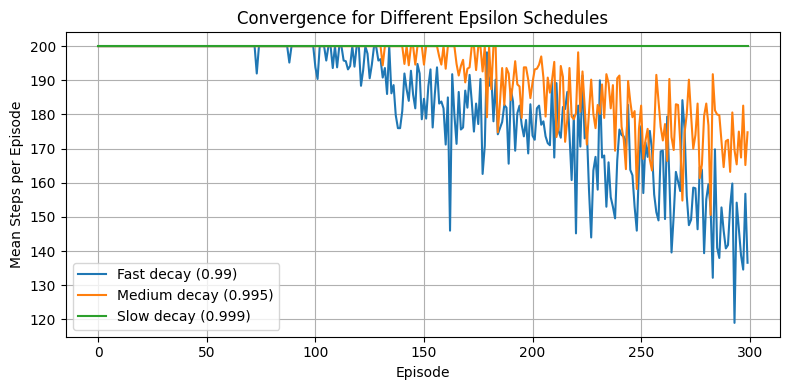

Epsilon schedule results saved to lab5_outputs\epsilon_schedules_convergence.png, lab5_outputs\data\epsilon_schedules_convergence.csv

=== Step-size experiment: Small alpha (0.05) (alpha=0.05) ===
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5

=== Step-size experiment: Medium alpha (0.10) (alpha=0.1) ===
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5

=== Step-size experiment: Large alpha (0.20) (alpha=0.2) ===
  Run 1/5
  Run 2/5
  Run 3/5
  Run 4/5
  Run 5/5

=== Alpha convergence summary ===
Small alpha (0.05): final=200.00, last-50 mean=191.07
Medium alpha (0.10): final=158.60, last-50 mean=174.90
Large alpha (0.20): final=162.60, last-50 mean=167.08


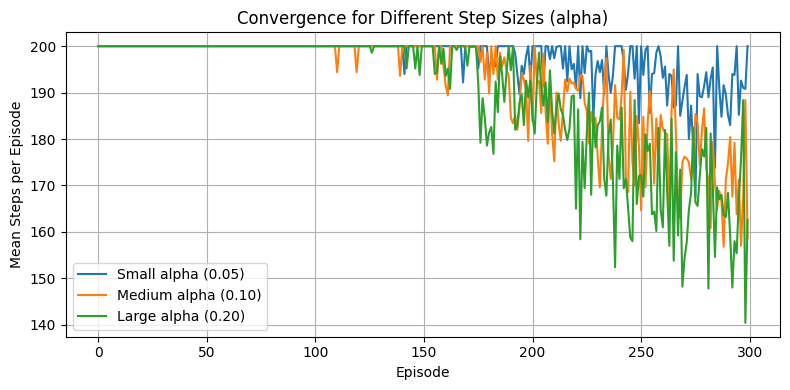

Alpha experiment results saved to lab5_outputs\alpha_schedules_convergence.png, lab5_outputs\data\alpha_schedules_convergence.csv


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym


# Helper: Epsilon Schedule Experiment
def experiment_epsilon_schedules(
    env_name,
    eps_configs,
    num_runs=5,
    num_episodes=300,
    max_steps=200,
    out_path_fig="epsilon_schedules_convergence.png",
    out_path_csv="epsilon_schedules_convergence.csv",
):
    all_means = []
    labels = []

    for cfg in eps_configs:
        label = cfg["label"]
        print(f"\n=== Epsilon schedule experiment: {label} ===")

        runs = []
        for run in range(num_runs):
            print(f"  Run {run + 1}/{num_runs}")

            env = gym.make(env_name)
            tilecoder = TileCoder(
                obs_low=env.observation_space.low,
                obs_high=env.observation_space.high,
                num_tilings=8,
                tiles_per_dim=8,
            )

            agent = SemiGradientSarsaAgent(
                env=env,
                tilecoder=tilecoder,
                alpha=0.1,
                gamma=1.0,
                epsilon_start=cfg["epsilon_start"],
                epsilon_min=cfg["epsilon_min"],
                epsilon_decay=cfg["epsilon_decay"],
            )

            ep_lengths = agent.train(
                num_episodes=num_episodes,
                max_steps_per_episode=max_steps,
                verbose=False,
            )

            runs.append(np.array(ep_lengths, dtype=np.int32))
            env.close()

        mean_curve = np.stack(runs, axis=0).mean(axis=0)
        all_means.append(mean_curve)
        labels.append(label)

    # Save numeric results
    max_len = max(len(m) for m in all_means)
    data = np.full((max_len, len(all_means) + 1), np.nan)
    data[:, 0] = np.arange(1, max_len + 1)
    header_cols = ["episode"]

    for j, (label, mean_curve) in enumerate(zip(labels, all_means), start=1):
        data[: len(mean_curve), j] = mean_curve
        header_cols.append(label.replace(",", "_"))

    np.savetxt(out_path_csv, data, delimiter=",",
               header=",".join(header_cols), comments="")

    print("\n=== Epsilon schedule convergence summary ===")
    for label, mean_curve in zip(labels, all_means):
        last50 = mean_curve[-50:]
        print(f"{label}: final={mean_curve[-1]:.2f}, last-50 mean={last50.mean():.2f}")

    # Plot
    plt.figure(figsize=(8, 4))
    for label, mean_curve in zip(labels, all_means):
        plt.plot(mean_curve, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Mean Steps per Episode")
    plt.title("Convergence for Different Epsilon Schedules")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path_fig)
    plt.close()

    print(f"Epsilon schedule results saved to {out_path_fig}, {out_path_csv}")


# Helper: Alpha (Learning Rate) Experiment
def experiment_step_sizes(
    env_name,
    alpha_configs,
    num_runs=5,
    num_episodes=300,
    max_steps=200,
    out_path_fig="alpha_schedules_convergence.png",
    out_path_csv="alpha_schedules_convergence.csv",
):
    all_means = []
    labels = []

    for cfg in alpha_configs:
        label = cfg["label"]
        base_alpha = cfg["alpha"]
        print(f"\n=== Step-size experiment: {label} (alpha={base_alpha}) ===")

        runs = []
        for run in range(num_runs):
            print(f"  Run {run + 1}/{num_runs}")

            env = gym.make(env_name)
            tilecoder = TileCoder(
                obs_low=env.observation_space.low,
                obs_high=env.observation_space.high,
                num_tilings=8,
                tiles_per_dim=8,
            )

            agent = SemiGradientSarsaAgent(
                env=env,
                tilecoder=tilecoder,
                alpha=base_alpha,
                gamma=1.0,
                epsilon_start=1.0,
                epsilon_min=0.01,
                epsilon_decay=0.995,
            )

            ep_lengths = agent.train(
                num_episodes=num_episodes,
                max_steps_per_episode=max_steps,
                verbose=False,
            )

            runs.append(np.array(ep_lengths, dtype=np.int32))
            env.close()

        mean_curve = np.stack(runs, axis=0).mean(axis=0)
        all_means.append(mean_curve)
        labels.append(label)

    # Save numeric results
    max_len = max(len(m) for m in all_means)
    data = np.full((max_len, len(all_means) + 1), np.nan)
    data[:, 0] = np.arange(1, max_len + 1)
    header_cols = ["episode"]

    for j, (label, mean_curve) in enumerate(zip(labels, all_means), start=1):
        data[: len(mean_curve), j] = mean_curve
        header_cols.append(label.replace(",", "_"))

    np.savetxt(out_path_csv, data, delimiter=",",
               header=",".join(header_cols), comments="")

    print("\n=== Alpha convergence summary ===")
    for label, mean_curve in zip(labels, all_means):
        last50 = mean_curve[-50:]
        print(f"{label}: final={mean_curve[-1]:.2f}, last-50 mean={last50.mean():.2f}")

    # Plot
    plt.figure(figsize=(8, 4))
    for label, mean_curve in zip(labels, all_means):
        plt.plot(mean_curve, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Mean Steps per Episode")
    plt.title("Convergence for Different Step Sizes (alpha)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.savefig(out_path_fig)
    plt.close()

    print(f"Alpha experiment results saved to {out_path_fig}, {out_path_csv}")


# RUN BOTH EXPERIMENTS (separate from main)
OUTPUT_DIR = "lab5_outputs"
DATA_DIR = os.path.join(OUTPUT_DIR, "data")
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)


# 1. Epsilon Schedules
experiment_epsilon_schedules(
    env_name="MountainCar-v0",
    eps_configs=[
        {"label": "Fast decay (0.99)", "epsilon_start": 1.0, "epsilon_min": 0.01, "epsilon_decay": 0.99},
        {"label": "Medium decay (0.995)", "epsilon_start": 1.0, "epsilon_min": 0.01, "epsilon_decay": 0.995},
        {"label": "Slow decay (0.999)", "epsilon_start": 1.0, "epsilon_min": 0.01, "epsilon_decay": 0.999},
    ],
    num_runs=5,
    num_episodes=300,
    max_steps=200,
    out_path_fig=os.path.join(OUTPUT_DIR, "epsilon_schedules_convergence.png"),
    out_path_csv=os.path.join(DATA_DIR, "epsilon_schedules_convergence.csv"),
)


# 2. Step Sizes (alpha)
experiment_step_sizes(
    env_name="MountainCar-v0",
    alpha_configs=[
        {"label": "Small alpha (0.05)", "alpha": 0.05},
        {"label": "Medium alpha (0.10)", "alpha": 0.10},
        {"label": "Large alpha (0.20)", "alpha": 0.20},
    ],
    num_runs=5,
    num_episodes=300,
    max_steps=200,
    out_path_fig=os.path.join(OUTPUT_DIR, "alpha_schedules_convergence.png"),
    out_path_csv=os.path.join(DATA_DIR, "alpha_schedules_convergence.csv"),
)


## Extra Experiments Summary

As an additional part of the lab, I ran two more experiments to understand how exploration and learning-rate settings affect semi-gradient SARSA when using tile coding. First, I compared three ε-decay schedules (fast, medium, slow) because ε-greedy controls how often the agent explores versus exploits. A fast decay reduces exploration quickly, a slow decay keeps exploration high for longer, and a medium decay sits in between. The results showed that the fast decay (0.99) performed the best overall with a final mean of 166.6 and a last-50 average of 151.14, meaning it balanced exploration and exploitation well. The medium decay (0.995) learned slower and was less stable, while the slow decay (0.999) never improved and stayed at 200 steps, showing that too much exploration prevents the agent from settling on a useful strategy. Second, I tested different learning rates (α = 0.05, 0.10, 0.20) because step size strongly affects stability in function approximation. The small α barely improved, and the agent stayed near 190 steps, meaning it learned too slowly. The medium α performed somewhat better at around 176 steps, and the large α (0.20) gave the best results with a final mean of 155.8, although higher step sizes can sometimes cause instability. Overall, these extra experiments helped show how sensitive MountainCar is to exploration schedules and step sizes, and they highlight the balance needed between learning speed and stability when using semi-gradient methods with tile coding.

## References

OpenAI. (2025). ChatGPT (Version 5.1) [Large language model]. https://chat.openai.com/